для Катруцы надо пояснить (из его фидкека): 
- что такое Транскиптомика 
- Как оценивается эффективность визуализаций

Ссылка на тензорли: 
Jean Kossaifi, Yannis Panagakis, Anima Anandkumar and Maja Pantic, **TensorLy: Tensor Learning in Python**, _Journal of Machine Learning Research (JMLR)_, 2019, volume 20, number 26.
```
Jean Kossaifi, Yannis Panagakis, Anima Anandkumar and Maja Pantic, **TensorLy: Tensor Learning in Python**, __Journal of Machine Learning Research (JMLR)__, 2019, volume 20, number 26.
```

alternatively
```
@article{tensorly,
  author  = {Jean Kossaifi and Yannis Panagakis and Anima Anandkumar and Maja Pantic},
  title   = {TensorLy: Tensor Learning in Python},
  journal = {Journal of Machine Learning Research},
  year    = {2019},
  volume  = {20},
  number  = {26},
  pages   = {1-6},
  url     = {http://jmlr.org/papers/v20/18-277.html}
}
```

ventromedial hypothalamus (VMH)


**Numerical Linear Tensor Kittens**
- Bogdan Kirillov
- Arman Petrosyants
- Svetlana Pavlova
- Dmitry Prodan

**Tensor factorization for transcriptomics**\
Low-dimensional data visualizations, such as t-SNE and UMAP, are among the most commonly used methods in transcriptomics. Unfortunately, due to the properties of t-SNE and UMAP, they have attracted a lot of criticism recently [1] as they fail to capture the global structure of the transcriptomics datasets. The goal of the project is to check whether we can substitute t-SNE and UMAP with matrix and tensor factorizations, such as SVD, PARAFAC [2], Tucker [3] and Tensor Train [4]. We plan to use the TensorLy library for our computations [5]. While tensor decompositions have been successfully used in transcriptomics [6,7], there yet to be a comparison of them to t-SNE and UMAP with respect to distortion analysis, similar to [1].

In-use:
- SVD
- Higher-order SVD
- PARAFAC
- Tucker decomposition
- Tensor Train.

References:
1. https://www.biorxiv.org/content/10.1101/2021.08.25.457696v1
2. https://www.sciencedirect.com/science/article/abs/pii/S0169743997000324
3. https://www.alexejgossmann.com/tensor_decomposition_tucker/
4. https://epubs.siam.org/doi/abs/10.1137/090752286?journalCode=sjoce3
5. http://tensorly.org/stable/index.html
6. https://www.nature.com/articles/ng.3624?proof=t
7. https://arxiv.org/abs/1702.07449

SMART_Seq VMN Neurons: 
- pairwise distance в исходном виде 
- pairwise distance после dimensionality reduction, 

из библиотек tensorly.
- Tucker, 
- Parafac, 
- Tensor Train 
- High-order SVD 

# Import and Handling

In [4]:
# !pip install -U --quiet tensorly anndata einops scikit-learn
import einops
import scipy.io as sio
import numpy as np
import pandas as pd
import tensorly as tl
import matplotlib.pyplot as plt

In [5]:
"""
smartseq.csv
smartseq.mtx 
smartseq_raw.mtx -> smartseq_hvg_raw.mtx
metadata.csv     -> smartseq_obs.csv 
gene_names.npy   -> SM_gene_names.npy
"""
data_path = "." 

In [6]:
smartseqmtx = sio.mmread(data_path + "/smartseq.mtx")

In [7]:
smartseq_obs = pd.read_csv(data_path + "/smartseq_obs.csv", index_col=0)
smartseq_obs.index = pd.Index([i for i in range(max(smartseq_obs.shape))])

rexp = "(?<=\_)(S.*?)(?=$|\_)"
ms = [item for sublist in smartseq_obs.sample_name.str.findall(rexp) for item in sublist]
smartseq_obs.insert(0, "master_sample", ms)

to_keep = list(filter(lambda x: x[1]>19, list(
    sorted(
        list(zip(*np.unique(smartseq_obs.master_sample.values, return_counts=True))), 
        key=lambda x: x[1]
    )
)))

to_keep = [a[0] for a in to_keep]
to_keep = [a in to_keep for a in smartseq_obs.master_sample]
smartseq_obs = smartseq_obs[to_keep]


to_keep = []
to_keep_sn = []
for a in smartseq_obs.groupby("master_sample"):
    to_keep_sn.extend([a[0]]*20)
    to_keep.extend(a[1].index.values[0:20])

to_keep = pd.DataFrame({"n": to_keep, "sn": to_keep_sn})

smartseq_obs = smartseq_obs[smartseq_obs.index.isin(to_keep.n.values)]

In [8]:
sns = to_keep["sn"].unique().tolist()

to_keep["sample_axis"] = to_keep["sn"].apply(lambda a: sns.index(a))

In [9]:
tens = smartseqmtx[to_keep["n"].values, :]
print(tens.shape)
smartseq_obs.master_sample.nunique()

(1900, 1999)


95

In [10]:
tens = einops.rearrange(tens, '(s c) g -> s c g', s=smartseq_obs.master_sample.nunique(), c=20)
tens.shape[0]

95

# Decompositions

In [15]:
$ git reset --soft HEAD~1

## 2-D case

In [12]:
sh_2d = (tens.shape[0]*tens.shape[1], tens.shape[2])
core, factors = tl.decomposition.tucker(tens.reshape(sh_2d), rank=[1000, 2])
pfactors = tl.decomposition.parafac(tens.reshape(sh_2d), 2)
core.shape, [a.shape for a in factors]

((1000, 2), [(1900, 1000), (1999, 2)])

In [13]:
(factors[0]@core).shape

(1900, 2)

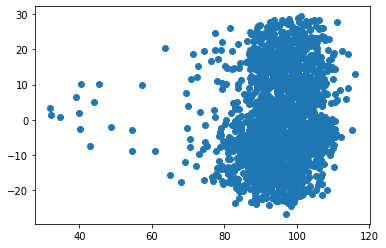

In [14]:
PCT = factors[0]@core
PCPF = pfactors[1][0]
plt.scatter(PCT.T[0], PCT.T[1])